In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from google.cloud import bigquery
from time import time
from tqdm import tqdm

## Create BQ Client

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/eduardchai/Workspace/NUS/eb5001-big-data-for-analytics/CA/big-data-ca-svc-acc.json"

In [4]:
client = bigquery.Client()

## Load data

In [5]:
sql = """
    SELECT *
    FROM `big-data-project-272506.yelp_dataset.restaurant_reviews_labeled`
"""

# Run a Standard SQL query using the environment's default project
df = client.query(sql).to_dataframe()

# Run a Standard SQL query with the project set explicitly
project_id = 'big-data-project-272506'
df = client.query(sql, project=project_id).to_dataframe()

In [6]:
df.loc[df.flagged == True, "flagged"] = 'Y'
df.loc[df.flagged == False, "flagged"] = 'N'

In [7]:
df.head()

,review_id,reviewer_id,restaurant_id,timestamp,rating,review_content,friend_count,review_count,useful_count,cool_count,funny_count,restaurant_rating,review_length,rating_deviation,maximum_review_per_user,cos_sim,flagged
0,04ysG-RSQGZV7sRMz71erw,jX4TK6exUYHD2It14AVWQQ,ElCbMJRjgu9LDj4MxOKXew,2008-07-27 00:00:00+00:00,4,i went opening big jones months ago wanted vis...,0,16,5,3,4,4.0,174,0.000,0.083333,0.189505,N
1,KfnPUynUi-kcnkxWP3srfw,y0EdiHf1fbpjYj2kJCOo2w,mlhHPnHmjO2_ypcP5Vc9Zw,2008-07-27 00:00:00+00:00,4,since i can t bring give sushi less 4 stars cu...,45,98,173,116,107,4.0,178,0.000,0.083333,0.193914,N
2,gXG9Mefjxn5cxZuoGlOOHg,II0AaBmdlsqEkiAGIf0LTQ,NGfbRjWoqUh2fGw8DU_pmA,2008-07-27 00:00:00+00:00,4,i wanting try place while my last attempt go t...,52,118,193,125,64,4.0,123,0.000,0.083333,0.253117,N
3,RlUwOr152LgaBypArWOrSA,ImQnqjGKSbfcgnz2ZPJrnw,4wreIFjaPMppyEnzKHbozg,2008-07-27 00:00:00+00:00,4,we went grand lux saturday night great experie...,0,2,0,0,0,3.5,54,0.125,0.083333,0.000000,Y
4,-JAZs7Y9MNfOCZjI5yY5Ug,HrTV66_qrreR4fWvspdJ9g,CQ75CQSyrsmb-S3UAwCHpw,2008-07-27 00:00:00+00:00,5,food 4 quality service made 5 stars my wife bo...,0,1,0,0,0,4.0,111,0.250,0.083333,0.000000,Y


## Utils

In [8]:
def under_sampling(df):
    print("Under-Sampling Data")
    # Count of Reviews
    sample_size = len(df[(df['flagged'] == 'Y')])

    authentic_reviews_df = df[df['flagged'] == 'N']
    fake_reviews_df = df[df['flagged'] == 'Y']

    authentic_reviews_us_df = authentic_reviews_df.sample(sample_size)
    under_sampled_df = pd.concat([authentic_reviews_us_df, fake_reviews_df], axis=0)
    print("Under-Sampling Complete")
    return under_sampled_df


def semi_supervised_learning(df, model, algorithm, threshold=0.8, iterations=40):
    df = df.copy()
    print("Training "+algorithm+" Model")
    labels = df['flagged']

    df.drop(['review_id', 'reviewer_id', 'restaurant_id', 'timestamp', 'flagged',
             'review_content', 'restaurant_rating'], axis=1, inplace=True)

    train_data, test_data, train_label, test_label = train_test_split(df, labels, test_size=0.25, random_state=42)

    test_data_copy = test_data.copy()
    test_label_copy = test_label.copy()

    all_labeled = False

    current_iteration = 0

    pbar = tqdm(total=iterations)

    while not all_labeled and (current_iteration < iterations):
        # print("Before train data length : ", len(train_data))
        # print("Before test data length : ", len(test_data))
        current_iteration += 1
        model.fit(train_data, train_label)

        probabilities = model.predict_proba(test_data)
        pseudo_labels = model.predict(test_data)

        indices = np.argwhere(probabilities > threshold)

        # print("rows above threshold : ", len(indices))
        for item in indices:
            train_data.loc[test_data.index[item[0]]] = test_data.iloc[item[0]]
            train_label.loc[test_data.index[item[0]]] = pseudo_labels[item[0]]
        test_data.drop(test_data.index[indices[:, 0]], inplace=True)
        test_label.drop(test_label.index[indices[:, 0]], inplace=True)
        print("After train data length : ", len(train_data))
        print("After test data length : ", len(test_data))
        print("--" * 20)

        if len(test_data) == 0:
            print("Exiting loop")
            all_labeled = True
        pbar.update(1)
    pbar.close()
    predicted_labels = model.predict(test_data_copy)

    # print('Best Params : ', grid_clf_acc.best_params_)
    print(algorithm + ' Model Results')
    print('--' * 20)
    print('Accuracy Score : ' + str(accuracy_score(test_label_copy, predicted_labels)))
    print('Precision Score : ' + str(precision_score(test_label_copy, predicted_labels, pos_label="Y")))
    print('Recall Score : ' + str(recall_score(test_label_copy, predicted_labels, pos_label="Y")))
    print('F1 Score : ' + str(f1_score(test_label_copy, predicted_labels, pos_label="Y")))
    print('Confusion Matrix : \n' + str(confusion_matrix(test_label_copy, predicted_labels)))
    plot_confusion_matrix(test_label_copy, predicted_labels, classes=['N', 'Y'],
                          title=algorithm + ' Confusion Matrix').show()


def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return plt

## Train the model

  0%|          | 0/3 [00:00<?, ?it/s]

Under-Sampling Data
Under-Sampling Complete
Training Random Forest Model


 33%|███▎      | 1/3 [00:14<00:29, 14.86s/it]

After train data length :  11836
After test data length :  576
----------------------------------------


 67%|██████▋   | 2/3 [00:21<00:12, 12.27s/it]

After train data length :  11922
After test data length :  490
----------------------------------------


100%|██████████| 3/3 [00:27<00:00,  9.01s/it]

After train data length :  11954
After test data length :  458
----------------------------------------


Random Forest Model Results
----------------------------------------
Accuracy Score : 0.8636803093780213
Precision Score : 0.8259818731117825
Recall Score : 0.9101198402130493
F1 Score : 0.8660120367437442
Confusion Matrix : 
[[1313  288]
 [ 135 1367]]


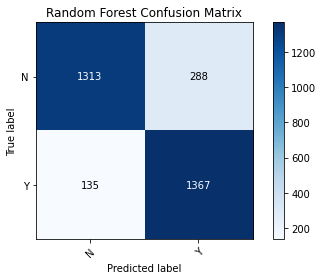

  0%|          | 0/3 [00:00<?, ?it/s]

Training Naive Bayes Model


100%|██████████| 3/3 [00:10<00:00,  3.59s/it]

After train data length :  12394
After test data length :  18
----------------------------------------
After train data length :  12402
After test data length :  10
----------------------------------------
After train data length :  12402
After test data length :  10
----------------------------------------
Naive Bayes Model Results
----------------------------------------
Accuracy Score : 0.7231711247180148
Precision Score : 0.6396005210594876
Recall Score : 0.9806924101198402
F1 Score : 0.7742444152431012
Confusion Matrix : 
[[ 771  830]
 [  29 1473]]


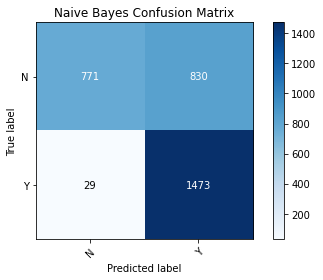

Time taken :  38.58566927909851


In [9]:
start_time = time()
under_sampled_df = under_sampling(df)
under_sampled_df.head()
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=14, max_features='auto', n_estimators=500)
nb = GaussianNB()

semi_supervised_learning(under_sampled_df, model=rf, threshold=0.7, iterations=3, algorithm='Random Forest')
semi_supervised_learning(under_sampled_df, model=nb, threshold=0.7, iterations=3, algorithm='Naive Bayes')
end_time = time()
print("Time taken : ", end_time - start_time)